In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, Embedding, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import LabelEncoder 
from tensorflow.keras.preprocessing import image
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import regularizers
from sklearn.metrics import r2_score
import shutil
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetB0
import math
from shutil import copy2

In [2]:
DATASET_PATH = "data"
print(os.listdir(DATASET_PATH))

['images', 'styles.csv']


In [3]:
IMAGE_PATH = 'data/images'

In [4]:
df = pd.read_csv("data/styles.csv", on_bad_lines='skip', sep=';')
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [5]:
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch,30039.jpg


In [6]:
# Menghapus kolom secara langsung
df.drop(columns=['year', 'articleType', 'productDisplayName','masterCategory'], inplace=True)
df.head()

,id,gender,subCategory,baseColour,season,usage,image
0,15970,Men,Topwear,Navy Blue,Fall,Casual,15970.jpg
1,39386,Men,Bottomwear,Blue,Summer,Casual,39386.jpg
2,59263,Women,Watches,Silver,Winter,Casual,59263.jpg
3,21379,Men,Bottomwear,Black,Fall,Casual,21379.jpg
4,53759,Men,Topwear,Grey,Summer,Casual,53759.jpg


In [7]:
df.isna().sum()

id               0
gender           0
subCategory      0
baseColour      15
season          21
usage          317
image            0
dtype: int64

In [8]:
df.dropna(inplace=True)
df.isna().sum()

id             0
gender         0
subCategory    0
baseColour     0
season         0
usage          0
image          0
dtype: int64

In [9]:
sub_categories = df['subCategory'].unique()
num_subcategories = len(sub_categories)
print(num_subcategories)

45


In [10]:
cols = 4
rows = (num_subcategories + cols - 1) // cols

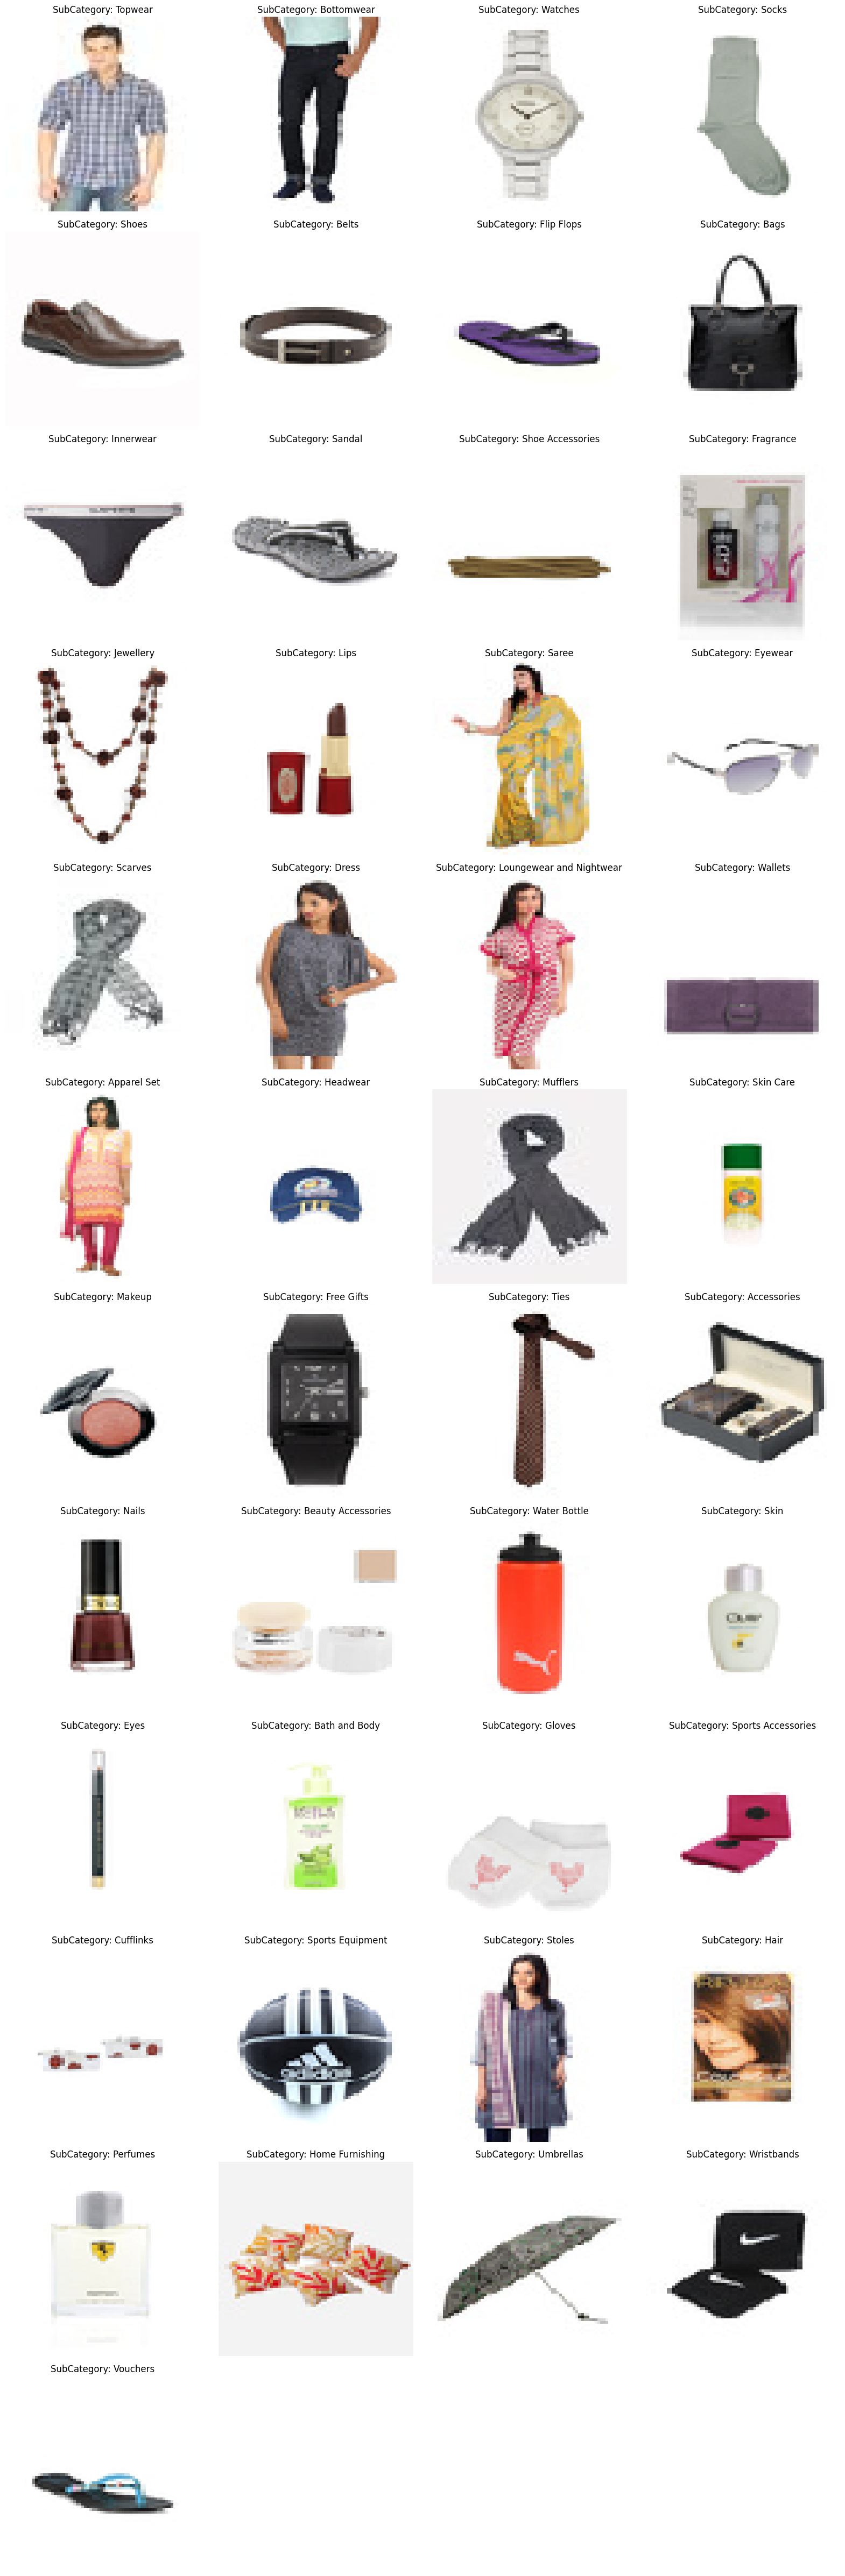

In [11]:
plt.figure(figsize=(cols * 4, rows * 4))  # Sesuaikan ukuran gambar di plot

# Iterasi melalui setiap subkategori
for i, sub_category in enumerate(sub_categories):
    # Ambil subset gambar untuk subkategori ini
    subset = df[df['subCategory'] == sub_category]
    
    # Pilih satu gambar secara acak dari subset
    random_image = subset.sample(1)
    
    # Ambil ID gambar dan path-nya
    img_id = random_image['id'].values[0]
    img_path = os.path.join(IMAGE_PATH, f"{img_id}.jpg")  # Sesuaikan ekstensi jika perlu
    
    # Load dan tampilkan gambar
    img = load_img(img_path, target_size=(72, 72))  # Ganti ukuran gambar jika perlu
    plt.subplot(rows, cols, i + 1)  # Tentukan ukuran grid dan posisi gambar
    plt.imshow(img)
    plt.title(f"SubCategory: {sub_category}")
    plt.axis('off')  # Matikan axis
    
# Tampilkan semua gambar
plt.tight_layout()
plt.show()

In [12]:
df['subCategory'] = df['subCategory'].astype(str) 

In [13]:
value_to_drop = ['Vouchers', 'Home Furnishing', 'Perfumes', 'Hair','Umbrellas','Cufflinks','Skin','Bath and Body', 'Eyes', 'Nails', 'Makeup', 'Ties', 'Skin Care', 'Innerwear', 'Jewellery','Lips', 'Fragrance', 'Shoe Accessories']

In [14]:
df.drop(df[df['subCategory'].isin(value_to_drop)].index, inplace=True)

In [15]:
sub_categories = df['subCategory'].unique()
num_subcategories = len(sub_categories)
print(num_subcategories)

27


In [16]:
df['subCategory'].unique()

array(['Topwear', 'Bottomwear', 'Watches', 'Socks', 'Shoes', 'Belts',
       'Flip Flops', 'Bags', 'Sandal', 'Saree', 'Eyewear', 'Scarves',
       'Dress', 'Loungewear and Nightwear', 'Wallets', 'Apparel Set',
       'Headwear', 'Mufflers', 'Free Gifts', 'Accessories',
       'Beauty Accessories', 'Water Bottle', 'Gloves',
       'Sports Accessories', 'Sports Equipment', 'Stoles', 'Wristbands'],
      dtype=object)

In [17]:
df['label'] = df['gender'] + "_" + df['season'] + "_" + df['baseColour'] + "_" + df['usage']+ "_" + df['subCategory']

In [18]:
df['label'].unique()

array(['Men_Fall_Navy Blue_Casual_Topwear',
       'Men_Summer_Blue_Casual_Bottomwear',
       'Women_Winter_Silver_Casual_Watches', ...,
       'Girls_Summer_Beige_Casual_Sandal',
       'Boys_Spring_Blue_Casual_Shoes',
       'Men_Spring_White_Sports_Bottomwear'], dtype=object)

In [19]:
df['id'] = df['id'].astype(str)

In [20]:
class_counts = df['label'].value_counts()
print(len(class_counts))

2827


In [21]:
df_filtered = df[~df['label'].isin(class_counts[class_counts < 100].index)]

In [22]:
df_filtered['label'].value_counts().min()

100

In [23]:
df_filtered.head(5)

,id,gender,subCategory,baseColour,season,usage,image,label
0,15970,Men,Topwear,Navy Blue,Fall,Casual,15970.jpg,Men_Fall_Navy Blue_Casual_Topwear
1,39386,Men,Bottomwear,Blue,Summer,Casual,39386.jpg,Men_Summer_Blue_Casual_Bottomwear
2,59263,Women,Watches,Silver,Winter,Casual,59263.jpg,Women_Winter_Silver_Casual_Watches
4,53759,Men,Topwear,Grey,Summer,Casual,53759.jpg,Men_Summer_Grey_Casual_Topwear
5,1855,Men,Topwear,Grey,Summer,Casual,1855.jpg,Men_Summer_Grey_Casual_Topwear


In [24]:
df_filtered['subCategory'].unique()

array(['Topwear', 'Bottomwear', 'Watches', 'Shoes', 'Bags', 'Eyewear',
       'Sandal', 'Wallets', 'Belts', 'Socks'], dtype=object)

In [25]:
# Menghapus baris berdasarkan kondisi
df_filtered.drop(df_filtered[df_filtered['id'] == '39403'].index, inplace=True)  # Menghapus baris dengan 'Male' di kolom 'gender'

In [26]:
# AUGMENTED_PATH = 'data/augmented_data'
# os.makedirs(AUGMENTED_PATH, exist_ok=True)

In [27]:
# for label in df_filtered['label'].unique():
#     print(f"Processing label: {label}")
    
#     # Buat folder untuk label ini
#     label_folder = os.path.join(AUGMENTED_PATH, label)
#     os.makedirs(label_folder, exist_ok=True)
    
#     # Ambil subset data untuk label ini
#     subset = df_filtered[df_filtered['label'] == label]
    
#     for _, row in subset.iterrows():
#         img_name = row['id'] + ".jpg"  # Sesuaikan dengan nama file gambar Anda
#         img_path = os.path.join(IMAGE_PATH, img_name)
        
#         # Load gambar
#         image = load_img(img_path)
#         image_array = img_to_array(image)
#         image_array = np.expand_dims(image_array, axis=0)  # Tambah batch dimension
        
#         # Generate augmentasi
#         augmented_images = datagen.flow(image_array, batch_size=1)
#         for i in range(5):  # Misal, buat 5 gambar augmented per gambar asli
#             aug_image = next(augmented_images)[0].astype('uint8')
#             aug_img_path = os.path.join(label_folder, f"{row['id']}_aug_{i}.jpg")
#             array_to_img(aug_image).save(aug_img_path)

In [28]:
IMAGE_PROCCESS = 'data/images_proccess'
os.makedirs(IMAGE_PROCCESS, exist_ok=True)

In [29]:
for label in df_filtered['label'].unique():
    print(f"Creating folder for label: {label}")
    
    # Pastikan label adalah string
    label = str(label)
    
    # Buat folder untuk label ini dalam 'images'
    label_folder = os.path.join(IMAGE_PROCCESS, label)
    os.makedirs(label_folder, exist_ok=True)
    
    # Ambil subset data untuk label ini
    subset = df_filtered[df_filtered['label'] == label]
    
    # Pindahkan gambar ke folder label yang sesuai
    for _, row in subset.iterrows():
        img_name = str(row['id']) + ".jpg"  # Sesuaikan dengan nama file gambar Anda
        img_path = os.path.join(IMAGE_PATH, img_name)
        
        # Cek apakah file gambar ada
        if os.path.exists(img_path):
            # Pindahkan gambar ke folder label
            shutil.copy(img_path, os.path.join(label_folder, img_name))
        else:
            print(f"File not found: {img_path}")

Creating folder for label: Men_Fall_Navy Blue_Casual_Topwear
Creating folder for label: Men_Summer_Blue_Casual_Bottomwear
Creating folder for label: Women_Winter_Silver_Casual_Watches
Creating folder for label: Men_Summer_Grey_Casual_Topwear
Creating folder for label: Women_Summer_Purple_Casual_Topwear
Creating folder for label: Men_Winter_Black_Casual_Watches
Creating folder for label: Men_Summer_Black_Casual_Shoes
Creating folder for label: Women_Summer_Brown_Casual_Bags
Creating folder for label: Women_Winter_Brown_Casual_Bags
Creating folder for label: Women_Winter_Black_Casual_Shoes
Creating folder for label: Women_Fall_Green_Ethnic_Topwear
Creating folder for label: Women_Summer_Pink_Casual_Topwear
Creating folder for label: Women_Winter_Brown_Casual_Shoes
Creating folder for label: Men_Fall_Grey_Casual_Topwear
Creating folder for label: Men_Fall_White_Sports_Shoes
Creating folder for label: Women_Winter_White_Casual_Watches
Creating folder for label: Men_Fall_Black_Formal_Shoes


In [30]:
# COMBINED_PATH = 'data/combined_images' 
# os.makedirs(COMBINED_PATH, exist_ok=True)

In [31]:
# def augment_images_to_balance(train_path, target_count, img_width, img_height):
#     # Inisialisasi ImageDataGenerator untuk augmentasi
#     datagen = ImageDataGenerator(
#         rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest'
#     )
    
#     # Iterasi setiap folder label di dalam train_path
#     label_folders = os.listdir(train_path)
#     for folder in label_folders:
#         folder_path = os.path.join(train_path, folder)
        
#         if os.path.isdir(folder_path):
#             images = os.listdir(folder_path)
#             image_count = len(images)
#             print(f"Folder {folder} memiliki {image_count} gambar.")
            
#             # Jika jumlah gambar sudah mencapai target_count, lewati
#             if image_count >= target_count:
#                 continue
            
#             # Ambil gambar-gambar untuk di-augmentasi
#             for img_name in images:
#                 img_path = os.path.join(folder_path, img_name)
                
#                 # Load gambar
#                 img = load_img(img_path, target_size=(img_width, img_height))
#                 img_array = img_to_array(img)
#                 img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimension
                
#                 # Hasilkan gambar augmentasi
#                 aug_iter = datagen.flow(img_array, batch_size=1)
                
#                 # Tambahkan gambar augmentasi hingga mencapai target_count
#                 for i in range(target_count - image_count):
#                     aug_img_array = next(aug_iter)[0]  # Ambil gambar augmentasi
#                     aug_img_path = os.path.join(folder_path, f"aug_{i}_{img_name}")
#                     save_img(aug_img_path, aug_img_array)
                
#                 # Perbarui jumlah gambar setelah augmentasi
#                 image_count = len(os.listdir(folder_path))
#                 if image_count >= target_count:
#                     break

In [32]:
label_folders = os.listdir(IMAGE_PROCCESS)
max_images = max([len(os.listdir(os.path.join(IMAGE_PROCCESS, folder))) for folder in label_folders])
print(max_images)

686


In [33]:
TARGET_COUNT = 686  # Misalnya targetkan 686 gambar per folder
IMG_WIDTH = 224  # Ukuran gambar 224x224
IMG_HEIGHT = 224

In [34]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [36]:
AUG_PATH = ('data/Augmented')
os.makedirs(AUG_PATH, exist_ok=True)

In [64]:
label_folders = os.listdir(IMAGE_PROCCESS)

# Iterasi untuk setiap kelas
for folder in label_folders:
    folder_path = os.path.join(IMAGE_PROCCESS, folder)
    output_folder_path = os.path.join(AUG_PATH, folder)
    
    # Pastikan subfolder input adalah direktori
    if os.path.isdir(folder_path):
        # Buat folder output untuk kelas
        os.makedirs(output_folder_path, exist_ok=True)
        
        # Salin semua gambar asli ke folder output terlebih dahulu
        original_images = os.listdir(folder_path)
        original_count = len(original_images)
        
        print(f"\nMemproses folder: {folder}")
        print(f"Jumlah gambar asli: {original_count}")
        
        # Salin gambar asli ke folder output
        for img_name in original_images:
            src_path = os.path.join(folder_path, img_name)
            dst_path = os.path.join(output_folder_path, img_name)
            copy2(src_path, dst_path)
        
        # Hitung berapa gambar augmentasi yang diperlukan
        augmentation_needed = TARGET_COUNT - original_count
        
        if augmentation_needed > 0:
            print(f"Perlu membuat {augmentation_needed} gambar augmentasi")
            augmentation_per_image = augmentation_needed // original_count
            extra_augmentation = augmentation_needed % original_count
            
            # Lakukan augmentasi untuk setiap gambar asli
            for idx, img_name in enumerate(original_images):
                img_path = os.path.join(folder_path, img_name)
                
                try:
                    # Load dan preprocess gambar
                    img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
                    img_array = img_to_array(img)
                    img_array = np.expand_dims(img_array, axis=0)
                    
                    # Tentukan berapa kali augmentasi untuk gambar ini
                    current_augmentations = augmentation_per_image
                    if idx < extra_augmentation:
                        current_augmentations += 1
                    
                    # Generate dan simpan gambar augmentasi
                    aug_iter = datagen.flow(
                        img_array,
                        batch_size=1,
                        save_to_dir=output_folder_path,
                        save_prefix=f'aug_{idx}',
                        save_format='jpg'
                    )
                    
                    for _ in range(current_augmentations):
                        next(aug_iter)
                        
                except Exception as e:
                    print(f"Error pada gambar {img_name}: {e}")
            
            # Hitung jumlah file hasil akhir
            final_count = len(os.listdir(output_folder_path))
            print(f"Jumlah akhir gambar di folder {folder}: {final_count}")
            if final_count != TARGET_COUNT:
                print(f"Warning: Target tidak tercapai. Selisih: {TARGET_COUNT - final_count}")
        else:
            print(f"Folder {folder} sudah memiliki cukup gambar ({original_count} >= {TARGET_COUNT})")


Memproses folder: Boys_Summer_White_Casual_Topwear
Jumlah gambar asli: 122
Perlu membuat 564 gambar augmentasi
Jumlah akhir gambar di folder Boys_Summer_White_Casual_Topwear: 685

Memproses folder: Men_Fall_Black_Casual_Shoes
Jumlah gambar asli: 230
Perlu membuat 456 gambar augmentasi
Jumlah akhir gambar di folder Men_Fall_Black_Casual_Shoes: 686

Memproses folder: Men_Fall_Black_Casual_Topwear
Jumlah gambar asli: 402
Perlu membuat 284 gambar augmentasi
Jumlah akhir gambar di folder Men_Fall_Black_Casual_Topwear: 686

Memproses folder: Men_Fall_Black_Formal_Shoes
Jumlah gambar asli: 101
Perlu membuat 585 gambar augmentasi
Jumlah akhir gambar di folder Men_Fall_Black_Formal_Shoes: 686

Memproses folder: Men_Fall_Black_Sports_Shoes
Jumlah gambar asli: 176
Perlu membuat 510 gambar augmentasi
Jumlah akhir gambar di folder Men_Fall_Black_Sports_Shoes: 686

Memproses folder: Men_Fall_Black_Sports_Topwear
Jumlah gambar asli: 136
Perlu membuat 550 gambar augmentasi
Jumlah akhir gambar di fold

In [65]:
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "val")
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(VAL_PATH, exist_ok=True)

In [66]:
def split_images_to_train_val(AUG_PATH, TRAIN_PATH, VAL_PATH, img_width, img_height, random_state=42):
    # Iterasi setiap folder label dalam IMAGE_PROCCESS
    label_folders = os.listdir(AUG_PATH)
    
    for folder in label_folders:
        folder_path = os.path.join(AUG_PATH, folder)
        
        if os.path.isdir(folder_path):
            # Buat folder untuk folder label di train dan val
            train_label_folder = os.path.join(TRAIN_PATH, folder)
            val_label_folder = os.path.join(VAL_PATH, folder)
            
            os.makedirs(train_label_folder, exist_ok=True)
            os.makedirs(val_label_folder, exist_ok=True)
            
            # Ambil semua gambar dalam folder label tersebut
            images = os.listdir(folder_path)
            
            # Bagi data gambar menjadi train dan val dengan random_state
            train_images, val_images = train_test_split(images, test_size=0.2, random_state=random_state)
            
            # Pindahkan gambar ke folder train
            for img_name in train_images:
                img_path = os.path.join(folder_path, img_name)
                if os.path.exists(img_path):
                    shutil.copy(img_path, os.path.join(train_label_folder, img_name))
                else:
                    print(f"File not found: {img_path}")
            
            # Pindahkan gambar ke folder validation
            for img_name in val_images:
                img_path = os.path.join(folder_path, img_name)
                if os.path.exists(img_path):
                    shutil.copy(img_path, os.path.join(val_label_folder, img_name))
                else:
                    print(f"File not found: {img_path}")

In [67]:
split_images_to_train_val(AUG_PATH, TRAIN_PATH, VAL_PATH, IMG_WIDTH, IMG_HEIGHT)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
) 


In [68]:
train_datagen = ImageDataGenerator(rescale=1.0/255,) 

In [69]:
val_datagen = ImageDataGenerator(rescale=1.0/255) 

In [79]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,               # Path ke folder data train
    target_size=(224, 224),   # Ukuran gambar yang akan diubah
    batch_size=64,            # Ukuran batch
    class_mode='categorical', # Mode kategori (untuk multi-class classification)
    shuffle = True
)

Found 44936 images belonging to 82 classes.


In [80]:
validation_generator = val_datagen.flow_from_directory(
    VAL_PATH,                 # Path ke folder data validation
    target_size=(224, 224),   # Ukuran gambar yang akan diubah
    batch_size=64,            # Ukuran batch
    class_mode='categorical', # Mode kategori (untuk multi-class classification)
    shuffle = False,
)

Found 11314 images belonging to 82 classes.


In [81]:
resnet_base = ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
resnet_base.trainable = False

In [ ]:
effe = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#effe.trainable = False

In [82]:
model = Sequential([
    resnet_base,
    GlobalAveragePooling2D(),
    Dense(82, activation='softmax')
])

In [83]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [84]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 82)                168018    
                                                                 
Total params: 23,755,730
Trainable params: 168,018
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(df_filtered['label'].values), 
    y=df_filtered['label'].values
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [86]:
history = model.fit(train_generator, epochs=500, validation_data=validation_generator)

Epoch 1/500
703/703 [==============================] - 212s 298ms/step - loss: 4.0925 - accuracy: 0.0862 - val_loss: 3.7526 - val_accuracy: 0.1218
Epoch 2/500
703/703 [==============================] - 169s 240ms/step - loss: 3.6155 - accuracy: 0.1356 - val_loss: 3.4051 - val_accuracy: 0.1507
Epoch 3/500
703/703 [==============================] - 160s 227ms/step - loss: 3.4524 - accuracy: 0.1562 - val_loss: 3.3899 - val_accuracy: 0.1552
Epoch 4/500
703/703 [==============================] - 160s 227ms/step - loss: 3.3492 - accuracy: 0.1682 - val_loss: 3.4705 - val_accuracy: 0.1636
Epoch 5/500
703/703 [==============================] - 160s 227ms/step - loss: 3.2490 - accuracy: 0.1837 - val_loss: 3.2470 - val_accuracy: 0.1895
Epoch 6/500
703/703 [==============================] - 160s 227ms/step - loss: 3.2208 - accuracy: 0.1904 - val_loss: 3.3174 - val_accuracy: 0.1785
Epoch 7/500
703/703 [==============================] - 160s 227ms/step - loss: 3.1359 - accuracy: 0.2021 - val_loss: 3

KeyboardInterrupt: 

In [87]:
def build_fine_tuned_resnet50(num_classes, input_shape=(224, 224, 3)):
    # Load base model
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze early layers
    for layer in base_model.layers[:-50]:  # Freeze all except last 50 layers
        layer.trainable = False
    
    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile model
    optimizer = Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [88]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint